In [1]:
%matplotlib notebook
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

In [101]:
raw_data = pd.read_csv('data.csv')
print (raw_data.shape)
data = raw_data[raw_data.runtype == 'collisions']
print (data.shape)


(3369, 403)
(1486, 403)


## Data Preprocessing and Scaling

In [102]:
data.loc[data.rda_name == '/PromptReco/Collisions2018A/DQM', 'era'] = 0

data.loc[data.rda_name == '/PromptReco/Collisions2018B/DQM', 'era'] = 1
data.loc[data.rda_name == '/PromptReco/Collisions2018C/DQM', 'era'] = 2
data.loc[data.rda_name == '/PromptReco/Collisions2018D/DQM', 'era'] = 3
data.loc[data.rda_name == '/PromptReco/HICollisions2018A/DQM', 'era'] = 4

run_numbers_0 = list(data.loc[data.era == 0.0, :].run_number.unique())
run_numbers_1 = list(data.loc[data.era == 1.0, :].run_number.unique())
run_numbers_2 = list(data.loc[data.era == 2.0, :].run_number.unique())
run_numbers_3 = list(data.loc[data.era == 3.0, :].run_number.unique())
run_numbers_4 = list(data.loc[data.era == 4.0, :].run_number.unique())

data.loc[data.run_number.isin(run_numbers_0), "era"] = 0
data.loc[data.run_number.isin(run_numbers_1), "era"] = 1
data.loc[data.run_number.isin(run_numbers_2), "era"] = 2
data.loc[data.run_number.isin(run_numbers_3), "era"] = 3
data.loc[data.run_number.isin(run_numbers_4), "era"] = 4

/Users/swappy/Documents/projects/tsc-cern/peter-anomaly-detection/venv/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/swappy/Documents/projects/tsc-cern/peter-anomaly-detection/venv/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [103]:
sum_of_eras = 0
for i in range(5):
    sum_of_eras += len(data[data.era==i])
    print(len(data[data.era==i]))
print(sum_of_eras)
print(len(data))

306
151
170
575
280
1482
1486


In [104]:
column_names = list(data.columns)
filtered_names = [a for a in column_names if 'rms' in a or 'mean' in a or 'lumisections' in a or a == 'recorded_lumi' or 'entries' in a or 'integral' in a or a=='era']
data.fillna(0, inplace=True)

# print(data[filtered_names].head())

plot_data = data.loc[:, filtered_names]
print(plot_data.shape)

(1486, 311)


/Users/swappy/Documents/projects/tsc-cern/peter-anomaly-detection/venv/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


### Label Filtering and One-hot Encoding

In [110]:
labels_binary = data.tracking
labels_multi = data.bad_reason
# Convert labels_binary to integer labels
labels_binary.index = range(len(labels_binary))
labels_binary.replace(to_replace='GOOD', value=1, inplace=True)
labels_binary.replace(to_replace='BAD', value=0, inplace=True)

/Users/swappy/Documents/projects/tsc-cern/peter-anomaly-detection/venv/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [111]:
def split_data_by_label(plot_data=None, labels_binary=None):
    plot_data = pd.DataFrame(plot_data)
    print("Total data:", len(plot_data))
    good_indices = labels_binary==1
    good_data = plot_data.loc[labels_binary==1]
    print ("Good data:", len(good_data))
    bad_indices = labels_binary==0
    bad_data = plot_data.loc[labels_binary==0]
    print ("Bad data:", len(bad_data))
    return good_data, bad_data

In [112]:
from matplotlib import pyplot as plt

def plot_scatter_2d(plot_data=None, ax_=None):
    
    good_data, bad_data = split_data_by_label(plot_data, labels_binary)
    if ax_ is None:
        fig_ = plt.figure()
        ax_ = plt.subplot()
    ax_.scatter(good_data.loc[:,0], good_data.loc[:, 1], label='Good')
    ax_.scatter(bad_data.loc[:,0], bad_data.loc[:, 1], label='Bad')
    plt.legend()
    return

In [113]:
from mpl_toolkits.mplot3d import Axes3D
 
def plot_scatter_3d(plot_data=None, ax_=None):
    good_data, bad_data = split_data_by_label(plot_data, labels_binary)
    if ax_ is None:
        fig_ = plt.figure()
        ax_ = Axes3D(fig_)
    print (len(good_data), len(bad_data))
    ax_.scatter(good_data.loc[:,0], good_data.loc[:, 1],  good_data.loc[:, 2], label='Good')
    ax_.scatter(bad_data.loc[:,0], bad_data.loc[:, 1], bad_data.loc[:, 2], label='Bad')
    plt.legend()
    return


In [114]:
# Check if data has any categorical features
for i in plot_data.values:
    if str(i[0].dtype) == 'float64':
        continue
    else:
        print('Categorical data found')

In [115]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

print (len(data))
pca = PCA(n_components=5)
pca_data = pca.fit_transform(scaler.fit_transform(plot_data.values))
print(pca.explained_variance_ratio_)
print(pca_data.shape)

1486
[0.45856686 0.23039091 0.10526903 0.05085737 0.03125667]
(1486, 5)


Total data: 1486
Good data: 1393
Bad data: 93


<IPython.core.display.Javascript object>


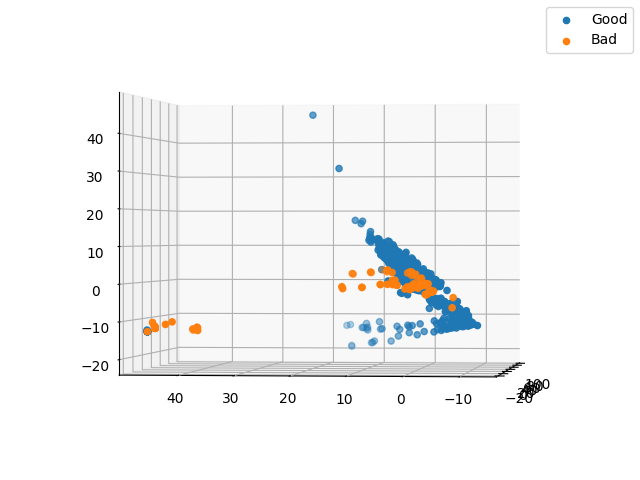

1393 93


In [117]:
plot_scatter_3d(pca_data)

In [108]:
%%time
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

sparse_pca = SparsePCA(n_components=5, normalize_components=True, random_state=0)
sparse_pca_data = sparse_pca.fit_transform(scaler.fit_transform(plot_data.values))
print(sparse_pca_data.shape)


(1486, 5)
CPU times: user 46.7 s, sys: 4.2 s, total: 50.9 s
Wall time: 23.6 s


Total data: 1486
Good data: 1393
Bad data: 93


<IPython.core.display.Javascript object>


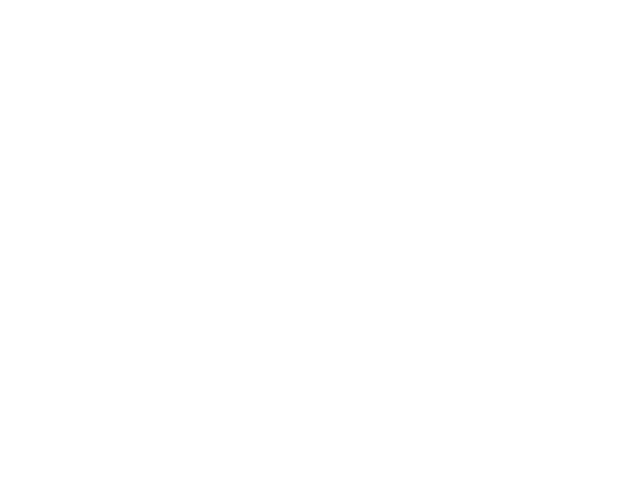

1393 93


In [124]:
plot_scatter_3d(np.transpose([sparse_pca_data[:,1], sparse_pca_data[:,2], sparse_pca_data[:,4]]))

(1486, 3)
Total data: 1486
Good data: 1393
Bad data: 93


<IPython.core.display.Javascript object>


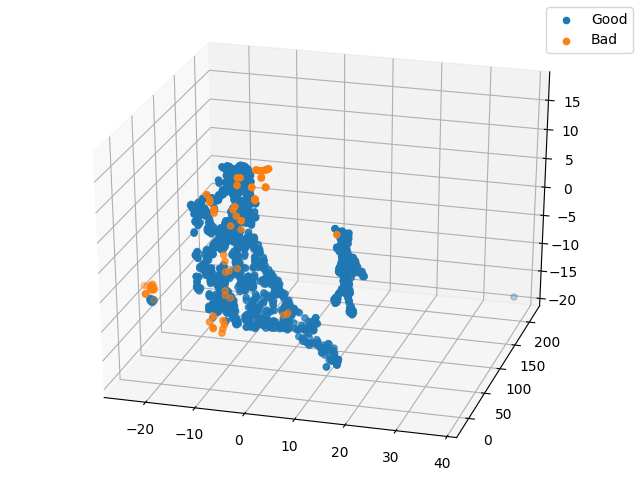

1393 93


In [120]:
%matplotlib notebook
%matplotlib notebook

from sklearn.manifold import TSNE
lr = 570
pp = 24
#for i in range(10):
#lr += 50
#pp += 10
tsne = TSNE(n_components=3, learning_rate=lr, n_iter=4200, perplexity=pp)
tsne_data = tsne.fit_transform(pca_data)
print(tsne_data.shape)
plot_scatter_3d(tsne_data)

## One-class Support Vector Machine

In [128]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(tsne_data, labels_binary, test_size=0.33, random_state=42)

clf = svm.OneClassSVM(nu=0.2, kernel="poly", gamma=0.3, cache_size=100)
clf.fit(X_train)


OneClassSVM(cache_size=100, coef0=0.0, degree=3, gamma=0.3, kernel='poly',
      max_iter=-1, nu=0.2, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

<IPython.core.display.Javascript object>


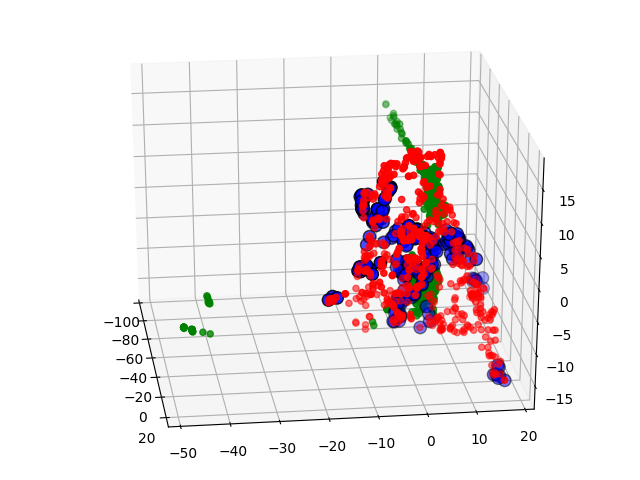

Here
There
Yo


In [145]:
y_pred_test = clf.predict(X_test)
plt.clf()
fig_ = plt.figure()
ax_ = Axes3D(fig_)
    
ax_.scatter3D(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], clf.support_vectors_[:, 2], s=80,
                facecolors='blue', zorder=10, edgecolors='black')
ax_.scatter3D(sparse_pca_data[:, 0], sparse_pca_data[:, 1], sparse_pca_data[:, 2], zorder=10, cmap=plt.cm.Paired,
               facecolors='green')

#plt.axis('tight')
x_min = -10
x_max = 10
y_min = -10
y_max = 10
a_min = -10
a_max = 10
b_min = -10
b_max = 10

print("Here")
XX, YY, AA = np.mgrid[x_min:x_max:50j, y_min:y_max:50j, a_min:a_max:50j]
Z = clf.decision_function(X_test)
print("There")
# Put the result into a color plot
#Z = Z.reshape(X_test.shape)
print("Yo")
# plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
ax_.scatter3D(X_test[:, 0], X_test[:, 1], X_test[:, 2], zorder=10, cmap=plt.cm.Paired,
               c='red')
plt.show()

In [ ]:
y_pred_test = clf.predict(X_test)
print(y_pred_test)

## Support Vector Machines

In [ ]:
## 2-D SVM

X = sparse_pca_data
Y = labels_binary

# fit the model
for kernel in ('linear', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=2)
    clf.fit(X, Y)

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.clf()

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10, edgecolors='k')
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
                edgecolors='k')

    plt.axis('tight')
    x_min = -50
    x_max = 50
    y_min = -50
    y_max = 50

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    #plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
     #           levels=[-.5, 0, .5])

    #plt.xlim(x_min, x_max)
    #plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()

## Local Outlier Factor

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

np.random.seed(42)

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate normal (not abnormal) training observations
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate new normal (not abnormal) observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model for novelty detection (novelty=True)
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)
# DO NOT use predict, decision_function and score_samples on X_train as this
# would give wrong results but only on new unseen data (not used in X_train),
# e.g. X_test, X_outliers or the meshgrid
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the learned frontier, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection with LOF")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "errors novel regular: %d/40 ; errors novel abnormal: %d/40"
    % (n_error_test, n_error_outliers))
plt.show()